# Tutorial - Using `fastai.data` low-level APIs

> Using `Datasets`, `Pipeline`, `TfmdLists` and `Transform`

## Overview

In this tutorial, we look in depth at the middle level API for collecting data in computer vision. First we will see how to use:

- `Transform` to process the data
- `Pipeline` to composes transforms

Those are just functions with added functionality. For dataset processing, we will look in a second part at 

- `TfmdLists` to apply one `Pipeline` of `Tranform`s on a collection of items
- `Datasets` to apply several `Pipeline` of `Transform`s on a collection of items in parallel and produce tuples

The general rule is to use `TfmdLists` when your transforms will output the tuple (input,target) and `Datasets` when you build separate `Pipeline`s for each of your input(s)/target(s). 

In [ ]:
from fastai2.vision.all import *

## Processing data

Cleaning and processing data is one of the most time-consuming things in machine learning, which is why fastai tries to help youas much as it can. At its core, preparing the data for your model can be formalized as a sequence of transformations you apply to some raw items. For instance, in a classic image classification problem, we start with filenames. We have to open the corresponding images, resize them, convert them to tensors, maybe apply some kind of data augmentation, before we are ready to batch them. And that's just for the inputs of our model, for the targets, we need to extract the label of our filename and convert it to an integer.

This process needs to be somewhat reversible, because we often want to inspect our data to double check what we feed the model actually makes sense. That's why fastai represents all those operations by `Transform`s, which you can sometimes undo with a `decode` method.

### Transform

First we'll have a look at the basic steps using a single MNIST image. We'll start with a filename, and see step by step how it can be converted in to a labelled image that can be displayed and used for modeling. We use the usual `untar_data` to download our dataset (if necessary) and get all the image files:

In [ ]:
source = untar_data(URLs.MNIST_TINY)/'train'
items = get_image_files(source)
fn = items[0]; fn

Path('/home/lgvaz/.fastai/data/mnist_tiny/train/7/730.png')

We'll look at each `Transform` needed in turn. Here's how we can open an image file:

In [ ]:
img = PILImage.create(fn); img

Then we can convert it to a `C*H*W` tensor (for channel x height x width, which is the convention in PyTorch):

In [ ]:
tconv = ToTensor()
img = tconv(img)
img.shape,type(img)

(torch.Size([3, 28, 28]), fastai2.torch_core.TensorImage)

Now that's done, we can create our labels. First extracting the text label:

In [ ]:
lbl = parent_label(fn); lbl

'7'

And then converting to an int for modeling:

In [ ]:
tcat = Categorize(vocab=['3','7'])
lbl = tcat(lbl); lbl

TensorCategory(1)

We use `decode` to reverse transforms for display. Reversing the `Categorize` transform result in a class name we can display:

In [ ]:
lbld = tcat.decode(lbl)
lbld

'7'

### Pipeline

We can compose our image steps using `Pipeline`:

In [ ]:
pipe = Pipeline([PILImage.create,tconv])
img = pipe(fn)
img.shape

torch.Size([3, 28, 28])

A `Pipeline` can decode and show an item.

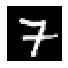

In [ ]:
pipe.show(img, figsize=(1,1), cmap='Greys');

The show method works behind the scenes with types. Transforms will make sure the type of an element they receive is preserved. Here `PILImage.create` returns a `PILImage`, which knows how to show itself. `tconv` converts it to a `TensorImage`, which also knows how to show itself.

In [ ]:
type(img)

fastai2.torch_core.TensorImage

Those types are also used to enable different behaviors depending on the input received (for instance you don't do data augmentation the same way on an image, a segmentation mask or a bounding box).

## Loading the Pets dataset using only `Transform`

Let's see how to use `fastai.data` to process the Pets dataset. We use *source* to refer to the underlying source of our data (e.g. a directory on disk, a database connection, a network connection, etc).

In [ ]:
source = untar_data(URLs.PETS)/"images"

First we grab the items and split indices:

In [ ]:
items = get_image_files(source)
split_idx = RandomSplitter()(items)

We'll use this function to create consistently sized tensors from image files:

In [ ]:
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).convert('RGB').resize((sz,sz))
    # Convert image to tensor for modeling
    return tensor(array(x)).permute(2,0,1).float()/255.

Before we can create a `Transform`, we need a type that knows how to show itself. Here we define a `TitledImage`:

In [ ]:
class TitledImage(Tuple):
    def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

In [ ]:
img = resized_image(items[0])

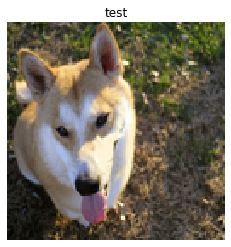

In [ ]:
TitledImage(img,'test').show()

### Try 1: State outside class

In [ ]:
class PetTfm(Transform):
    def __init__(self, vocab, o2i, lblr): self.vocab,self.o2i,self.lblr = vocab,o2i,lblr
    def encodes(self, o): return [resized_image(o), self.o2i[self.lblr(o)]]
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

In [ ]:
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
vals = list(map(labeller, items[split_idx[0]]))
vocab,o2i = uniqueify(vals, sort=True, bidir=True)
pets = PetTfm(vocab,o2i,labeller)

In [ ]:
x,y = pets(items[0])
x.shape,y

(torch.Size([3, 128, 128]), 33)

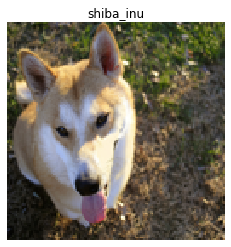

In [ ]:
dec = pets.decode([x,y])
dec.show()

### Try 2: State inside class

We can now create a `Transform` that converts from an index to our `x` and `y` for modeling.

In [ ]:
class PetTfm(Transform):
    def __init__(self, items, train_idx):
        self.items,self.train_idx = items,train_idx
        self.labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
        vals = map(self.labeller, items[train_idx])
        self.vocab,self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, i):
        o = self.items[i]
        return [resized_image(o), self.o2i[self.labeller(o)]]
    
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

Note that `decodes` is intended to operate on the return value of `encodes`. In the case above, `decodes` takes in a tuple consisting of a Tensor representing the image and an integer being the class idx and returns an instance of `TitledImage`.

It's important to give the type that can show itself to fully decoded elements because when in a `Pipeline`, we stop decoding as soon as we can find a `show` method.

In [ ]:
pets = PetTfm(items, split_idx[0])

In [ ]:
x,y = pets(0)
x.shape,y

(torch.Size([3, 128, 128]), 33)

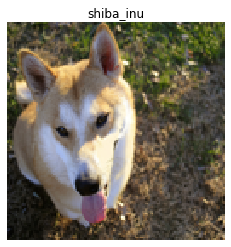

In [ ]:
dec = pets.decode([x,y])
dec.show()

## Using `Pipeline` to create Siamese model dataset

Here we create a `SiameseImage` object that subclasses `Tuple` and is intended to contain three things: two images, and a boolean that's `True` if they are the same breed. We also implement the special `show` method, such that it concatenates the two images, with a black line in the middle. Don't worry too much about the part that is in the `if` test (which is to show the `SiameseImage` when the images are Pillow images, and not tensors), the important part is in the last three lines.

In [ ]:
class SiameseImage(Tuple):
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self
        if not isinstance(img1, Tensor):
            if img2.size != img1.size: img2 = img2.resize(img1.size)
            t1,t2 = tensor(img1),tensor(img2)
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)
        return show_image(torch.cat([t1,line,t2], dim=2), 
                          title=same_breed, ctx=ctx)

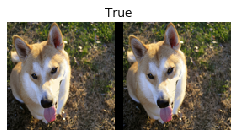

In [ ]:
SiameseImage(img,img,True).show();

We create a `SiamesePair` transform that creates the tuple we'll need for a `SiameseImage`.

In [ ]:
class SiamesePair(Transform):
    def __init__(self,items,labels):
        self.items,self.labels,self.assoc = items,labels,self
        sortlbl = sorted(enumerate(labels), key=itemgetter(1))
        # dict of (each unique label) -- (list of indices with that label)
        self.clsmap = {k:L(v).itemgot(0) for k,v in itertools.groupby(sortlbl, key=itemgetter(1))}
        self.idxs = range_of(self.items)
        
    def encodes(self,i):
        "x: tuple of `i`th image and a random image from same or different class; y: True if same class"
        othercls = self.clsmap[self.labels[i]] if random.random()>0.5 else self.idxs
        otherit = random.choice(othercls)
        return SiameseImage(self.items[i], self.items[otherit], self.labels[otherit]==self.labels[i])

We want to open and resize the image filenames but not the boolean. A special behavior of `Transform`s is that they always get applied over tuples and it's subclasses (and our `SiameseImage` inherits from `Tuple`). This means that instead of a `Transform` being applied over a tuple, it's instead applied individually to each item, and with type dispatching, we can then create a new transform that opens and resizes `Path` objects but leaves other types untouched. 

Then the `Pipeline` will compose our two transforms, and create the `SiameseImage`.

In [ ]:
OpenAndResize = Transform(resized_image)
labeller = RegexLabeller(pat = r'/([^/]+)_\d+.jpg$')
sp = SiamesePair(items, items.map(labeller))
pipe = Pipeline([sp, OpenAndResize])
x,y,z = t = pipe(0)
x.shape,y.shape,z

(torch.Size([3, 128, 128]), torch.Size([3, 128, 128]), False)

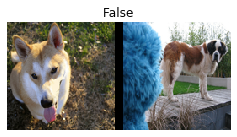

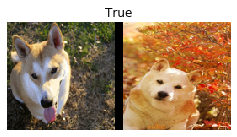

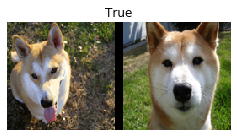

In [ ]:
for _ in range(3): pipe.show(pipe(0))

## Using `Datasets`

`Datasets` applies a list of list of transforms (or list of `Pipeline`s) lazily to items of a collection, creating one output per list of transforms/`Pipeline`. This makes it easier for us to separate out steps of a process, so that we can re-use them and modify the process more easily. For instance, we could add data augmentation, data normalization, etc. Here we separate out the steps of the basic pets process.

In [ ]:
class ImageResizer(Transform):
    order=0
    "Resize image to `size` using `resample`"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): size=(size,size)
        self.size,self.resample = (size[1],size[0]),resample

    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)
    def encodes(self, o:PILMask):  return o.resize(size=self.size, resample=Image.NEAREST)

In [ ]:
tfms = [[PILImage.create, ImageResizer(128), ToTensor(), IntToFloatTensor()],
        [labeller, Categorize()]]
dsets = Datasets(items, tfms)

In [ ]:
t = dsets[0]
type(t[0]),type(t[1])

(fastai2.torch_core.TensorImage, fastai2.torch_core.TensorCategory)

In [ ]:
x,y = dsets.decode(t)
x.shape,y

(torch.Size([3, 128, 128]), 'shiba_inu')

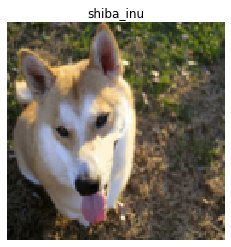

In [ ]:
dsets.show(t);

The types are being properly propagated and dispatched, we can do the same thing with `ImageResizer`, `ImageToByteTensor`, `IntToFloatTensor` being passed as transforms over the tuple. This is done in `TfmdDL` by passing them to `after_item`. They won't do anything to the category but will only be applied to the inputs.

In [ ]:
tfms = [[PILImage.create], [labeller, Categorize()]]
dsets = Datasets(items, tfms)
tdl = TfmdDL(dsets, bs=1, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])

In [ ]:
t = tdl.one_batch()
x,y = tdl.decode_batch(t)[0]
x.shape,y

(torch.Size([3, 128, 128]), 'shiba_inu')

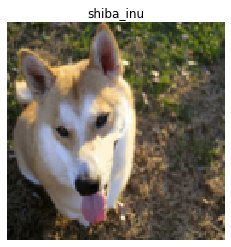

In [ ]:
dsets.show((x,y))

## Adding splits

When you create a `Datasets` object, you can pass along `splits` indices that represent the split between train and validation set (there can be multiple validation sets) on top of the items and tfms.

In [ ]:
pets = Datasets(items, tfms, splits=split_idx)

To access an element we need to specify the subset (either with `train`/`valid` or with `subset(i)`):

In [ ]:
x,y = pets.subset(1)[0]
x.shape,y

((500, 500), TensorCategory(5))

...or equivalently:

In [ ]:
x2,y2 = pets.valid[0]
test_eq(x.shape,x2.shape)
test_eq(y,y2)

We can decode an element for display purposes, either passing a tuple to `decode` or by passing an index to `decode_at`.

In [ ]:
xy = pets.valid.decode((x,y))
xy[1]

'Egyptian_Mau'

In [ ]:
xy2 = decode_at(pets.valid, 0)
test_eq(type(xy2[1]), Category)
test_eq(xy2, xy)

We're now ready to show our items.

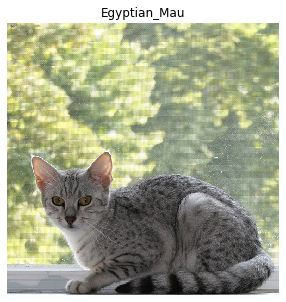

In [ ]:
pets.show((x,y))

We can use this to feed a `DataLoader` and view a batch. It's faster to convert to float on GPU, so we'll do it as a DataLoader transform in `after_batch`. We have to set the `device` in ` TfmdDL` as it's `None` by default.

In [ ]:
item_img_tfms = [ImageResizer(128), ToTensor()]
batch_tfms = [IntToFloatTensor()]

trn_dl = TfmdDL(pets.train, bs=9, after_item=item_img_tfms, after_batch=batch_tfms, device=default_device())
b = trn_dl.one_batch()

test_eq(len(b[0]), 9)
test_eq(b[0][0].shape, (3,128,128))
test_eq(b[0].type(), 'torch.cuda.FloatTensor' if default_device().type=='cuda' else 'torch.FloatTensor')

In [ ]:
bd = trn_dl.decode_batch(b)

test_eq(len(bd), 9)
test_eq(bd[0][0].shape, (3,128,128))

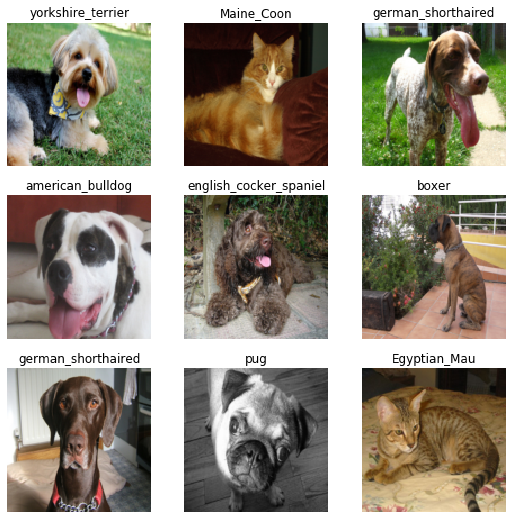

In [ ]:
trn_dl.show_batch()

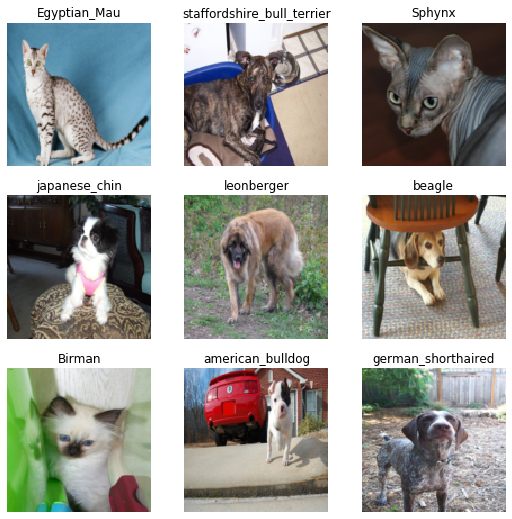

In [ ]:
dls = pets.dataloaders(bs=9, after_item=item_img_tfms, after_batch=batch_tfms)
dls.train.show_batch()

In [ ]:
dls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

## Segmentation

By using the same transforms in `after_item` and `after_batch` but a different kind of targets (here segmentation masks), the targets are automatically processed as they should with the type-dispatch system.

In [ ]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/'images')
cv_splitter = RandomSplitter(seed=42)
cv_split = cv_splitter(cv_items)
cv_label = lambda o: cv_source/'labels'/f'{o.stem}_P{o.suffix}'

In [ ]:
tfms = [[PILImage.create], [cv_label, PILMask.create]]
camvid = Datasets(cv_items, tfms, splits=cv_split)
trn_dl = TfmdDL(camvid.train,  bs=4, after_item=item_img_tfms, after_batch=batch_tfms)

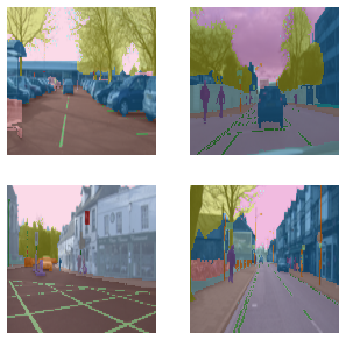

In [ ]:
trn_dl.show_batch()

## Adding a test dataloader for inference

Let's take back our pets dataset...

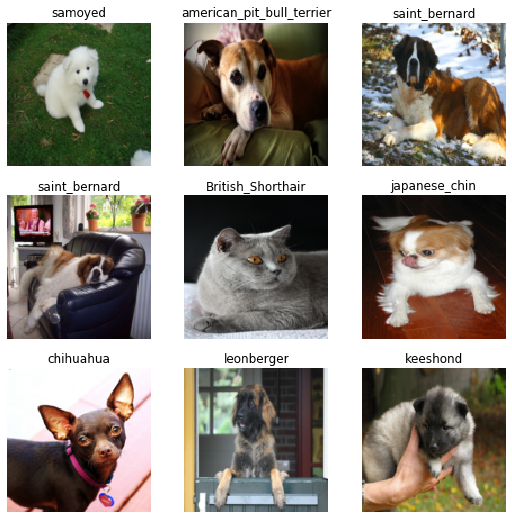

In [ ]:
dls = pets.dataloaders(bs=9, after_item=item_img_tfms, after_batch=batch_tfms)
dls.train.show_batch()

...and imagine we have some new files to classify.

In [ ]:
path = untar_data(URLs.PETS)
tst_files = get_image_files(path/"images")

In [ ]:
len(tst_files)

7390

We can create a dataloader that takes those files and applies the same transforms as the validation set with `DataLoaders.test_dl`.

In [ ]:
tst_dl = dls.test_dl(tst_files)

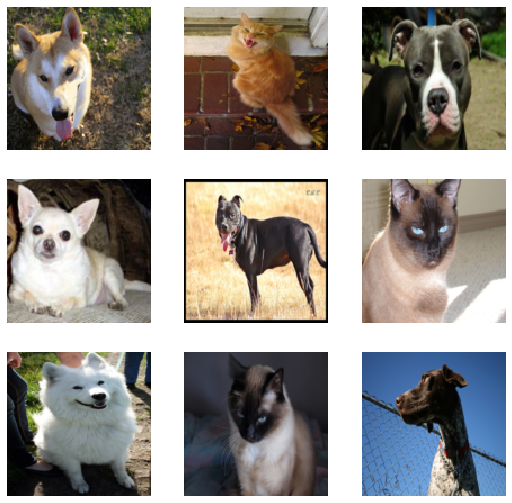

In [ ]:
tst_dl.show_batch(max_n=9)

**Extra:**  
You can call `learn.get_preds` passing this newly created dataloaders to make predictions on our new images!  
What is really cool is that after you finished training your model, you can save it with `learn.export`, this is also going to save all the transforms that need to be applied to your data. In inference time you just need to load your learner with `load_learner` and you can immediately create a dataloader with `test_dl` to use it to generate new predictions!

## fin -